In [1]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import itertools


## Original data and its distribution visualization 

In [2]:
df_iris=pd.read_csv(r'D:\data_sec\IRIS.csv')
df_iris['species'] = df_iris['species'].astype('category')  

In [3]:
def plot_feature_pairs(df, label_column='species', figsize=(16, 12)):
    features = df.select_dtypes(include='number').columns.tolist()
    feature_pairs = list(itertools.combinations(features, 2))

    plt.figure(figsize=figsize)
    for i, (x_feat, y_feat) in enumerate(feature_pairs, 1):
        plt.subplot(2, 3, i)
        for label in df[label_column].unique():
            subset = df[df[label_column] == label]
            plt.scatter(subset[x_feat], subset[y_feat], label=label, alpha=0.7)
        plt.xlabel(x_feat)
        plt.ylabel(y_feat)
        plt.title(f'{x_feat} vs {y_feat}')
        plt.legend()
    plt.tight_layout()
    plt.show()

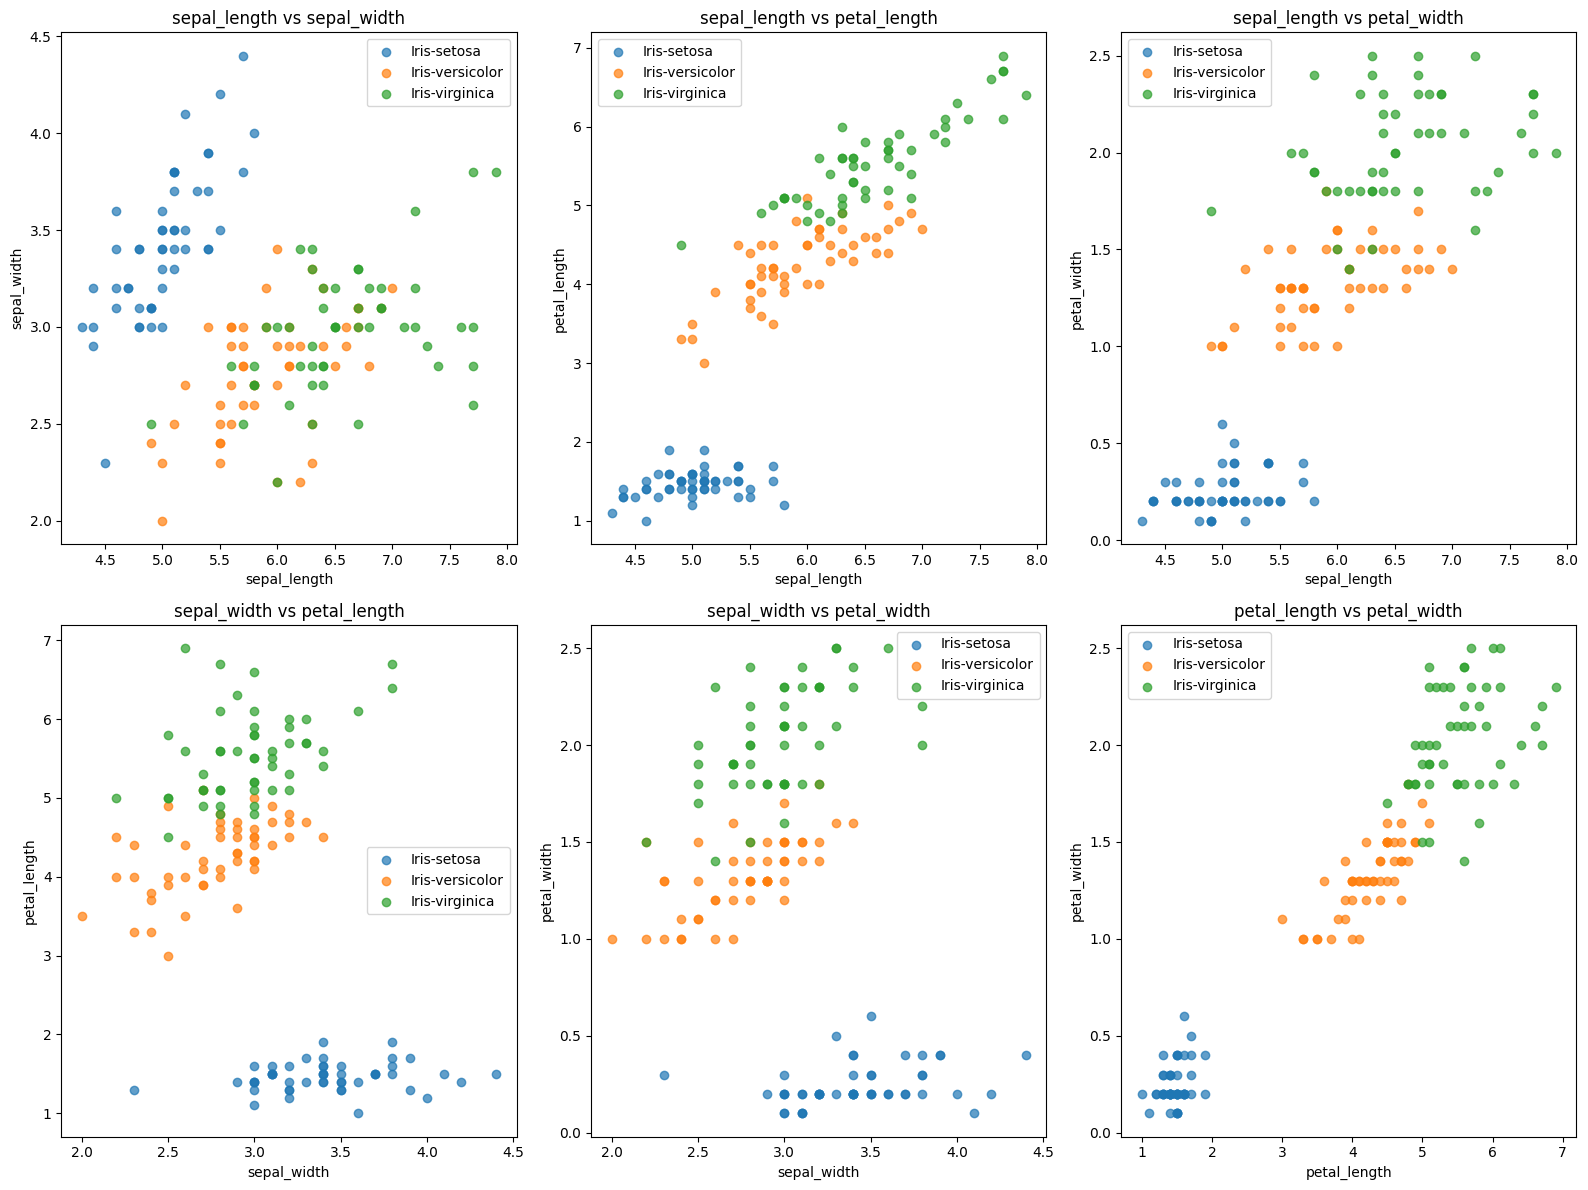

In [4]:
plot_feature_pairs(df_iris, label_column='species', figsize=(16, 12))